# IESEG School of Management
# Credit Scoring
Ashwani Nitharwal

## Importing Libraries and dataset

In [854]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
pd.set_option('display.max_columns', None)
from collections import defaultdict
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble           import RandomForestClassifier

In [855]:
#importing accept and reject dataset
accept = pd.read_csv('Data/RealEstateLoans_accepts.csv')
reject = pd.read_csv('Data/RealEstateLoans_rejects.csv')

Dataset: Accept/Reject

- Accept - It shows all the data of the loan applications which were accepted
- Reject - It shows all the data of the loan applications which were rejected

Data Pre-processing:
- Treating outliers: Removing the rows 
- NAs: Filling categorical variables with 'Unknown' and continuous variable with 0

In [856]:
#pre-processing, treating NAs in both accept and reject
accept['occupation_type'] = accept['occupation_type'].fillna('Unknown')
accept['EXT1'] = accept['EXT1'].fillna(0)
accept['EXT2'] = accept['EXT2'].fillna(0)
accept['EXT3'] = accept['EXT3'].fillna(0)

reject['occupation_type'] = reject['occupation_type'].fillna('Unknown')
reject['EXT1'] = reject['EXT1'].fillna(0)
reject['EXT2'] = reject['EXT2'].fillna(0)
reject['EXT3'] = reject['EXT3'].fillna(0)

In [857]:
#exploring dataset
accept.shape

(18549, 29)

In [858]:
#exploring dataset
reject.shape

(9112, 28)

In [859]:
accept.head(3)

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,housing_type,region_population_ratio,days_birth,days_employed,days_registration,mobile_number,phone_number,email,days_phone_change,occupation_type,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,Default
0,157500.00000,288562.50000,30,3.73740,Y,N,0,Commercial associate,Secondary / secondary special,Married,Apartment,0.02516,-11966,-229,-979.00000,1,0,0,0.00000,Drivers,2.00000,0.00000,0.54131,0.23661,0,0,0,0,0
1,76500.00000,225000.00000,48,3.65430,N,Y,3,Working,Secondary / secondary special,Separated,Co-op house,0.02866,-10461,-2371,-1050.00000,1,0,0,-2547.00000,Laborers,4.00000,0.00000,0.39542,0.67383,0,1,0,0,0
2,67500.00000,409653.00000,12,3.26286,Y,N,0,Working,Secondary / secondary special,Civil marriage,House,0.03579,-11130,-1188,-4868.00000,1,0,0,-1502.00000,Laborers,2.00000,0.00000,0.64942,0.04293,0,1,0,0,1


In [860]:
accept.columns

Index(['total_income', 'loan_amount', 'term', 'interest_rate', 'own_car',
       'own_house', 'nr_children', 'income_type', 'education_type',
       'family_status', 'housing_type', 'region_population_ratio',
       'days_birth', 'days_employed', 'days_registration', 'mobile_number',
       'phone_number', 'email', 'days_phone_change', 'occupation_type',
       'family_count', 'EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7',
       'Default'],
      dtype='object')

In [861]:
#treating outliers of continuous variable
from scipy import stats

cols = ['total_income', 'loan_amount', 'term', 'interest_rate', 'days_birth', 'days_employed', 'days_registration',
       'days_phone_change','EXT1', 'EXT2', 'EXT3']

get_iqr = lambda x: {"lower":x.quantile(0.25) - 1.5 * stats.iqr(x), "upper":x.quantile(0.75) + 1.5 * stats.iqr(x)}

# compute iqr
iqr = accept[cols].apply(get_iqr)

# remove outliers
for col, bounds in zip(cols, iqr):
    rows_before = accept.shape[0]
    accept_iqr = accept[(accept[col] < bounds["upper"]) & (bounds["lower"] < accept[col])].reset_index(drop=True)
    print(f"{col}: removed {rows_before-accept_iqr.shape[0]} rows ...")


total_income: removed 925 rows ...
loan_amount: removed 393 rows ...
term: removed 0 rows ...
interest_rate: removed 236 rows ...
days_birth: removed 0 rows ...
days_employed: removed 4438 rows ...
days_registration: removed 45 rows ...
days_phone_change: removed 22 rows ...
EXT1: removed 0 rows ...
EXT2: removed 0 rows ...
EXT3: removed 0 rows ...


## Data Exploration
- After pre-processing, exploring the data and getting understanding of the population using visualizations

Data Exploration gives us the basic idea about the distribution of data as well as getting to know the data

In [862]:
accept.head(2)

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,housing_type,region_population_ratio,days_birth,days_employed,days_registration,mobile_number,phone_number,email,days_phone_change,occupation_type,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,Default
0,157500.00000,288562.50000,30,3.73740,Y,N,0,Commercial associate,Secondary / secondary special,Married,Apartment,0.02516,-11966,-229,-979.00000,1,0,0,0.00000,Drivers,2.00000,0.00000,0.54131,0.23661,0,0,0,0,0
1,76500.00000,225000.00000,48,3.65430,N,Y,3,Working,Secondary / secondary special,Separated,Co-op house,0.02866,-10461,-2371,-1050.00000,1,0,0,-2547.00000,Laborers,4.00000,0.00000,0.39542,0.67383,0,1,0,0,0


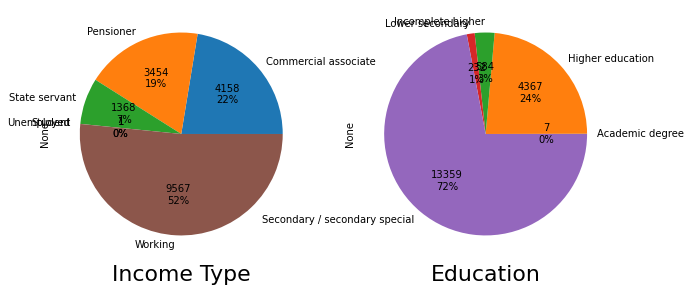

In [863]:
# Analyzing income_type and Education distribution
def label_function(val):
    return f'{val / 100 * len(accept):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

accept.groupby('income_type').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10}, ax=ax1)
accept.groupby('education_type').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 ax=ax2)
ax1.set_xlabel('Income Type', size=22)
ax2.set_xlabel('Education', size=22)#plt.tight_layout()
plt.show()

<AxesSubplot:ylabel='occupation_type'>

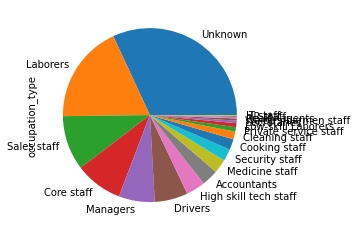

In [864]:
# Analyzing occupation_type
accept['occupation_type'].value_counts().plot(kind='pie')

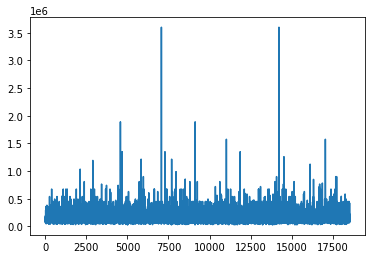

In [788]:
# Value span of total_income 
plt.plot(accept['total_income'])

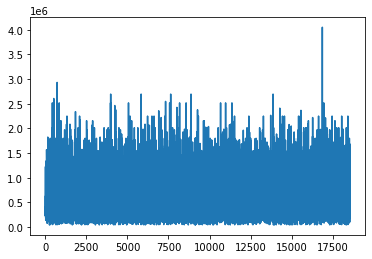

In [852]:
#Analysis of loan_amount: Most of the amounts are in the common range 
plt.plot(accept['loan_amount'])

## WOE Encoding
- WOE encoding to treat the categorical variables
- Based on the WOE values, the categorical values are merged into less categories within a column (also called Binning)
- treating binary variables and replacing them with 0 and 1

Weight of Evidence (WoE) measures the “strength” of a grouping technique to separate good and bad. This method was developed primarily to build a predictive model to evaluate the risk of loan default in the credit and financial industry. Weight of evidence (WOE) measures how much the evidence supports or undermines a hypothesis.

WoE will be 0 if the P(Goods) / P(Bads) = 1. That is, if the outcome is random for that group. If P(Bads) > P(Goods) the odds ratio will be < 1 and the WoE will be < 0; if, on the other hand, P(Goods) > P(Bads) in a group, then WoE > 0.

Reference: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

In [789]:
from category_encoders import WOEEncoder

# WOE encode for the categorical variables
ce_woe = WOEEncoder()
woe_model = ce_woe.fit(X=accept[['income_type','education_type','family_status','housing_type','occupation_type']], y=accept["Default"])
p = woe_model.transform(accept[['income_type','education_type','family_status','housing_type','occupation_type']])
q = woe_model.transform(reject[['income_type','education_type','family_status','housing_type','occupation_type']])

In [790]:
#replacing the WOE values in the dataset
accept[['income_type','education_type','family_status','housing_type','occupation_type']] = p[['income_type','education_type','family_status','housing_type','occupation_type']].values
reject[['income_type','education_type','family_status','housing_type','occupation_type']] = q[['income_type','education_type','family_status','housing_type','occupation_type']].values

In [791]:
#treating binary variables to 0 and 1
accept['own_car'] = accept['own_car'].map({'Y':1,'N':0})
accept['own_house'] = accept['own_house'].map({'Y':1,'N':0})

reject['own_car'] = reject['own_car'].map({'Y':1,'N':0})
reject['own_house'] = reject['own_house'].map({'Y':1,'N':0})

## Reject Inference and Accuracies
- After getting the data ready, i took few steps:
1. Splitted the data into train(60%), valid(20%), test(20%).
2. Setup the models and run it on the accept data (validation set and test set) to check the feature importance and get the overview of probabilities.
3. Used the same model to predict on the rejects data so that i can cut-off the 15% of the most probable rejects and label them as accepted. (this will make the model more adaptable to the future as it's trained for more such data)
4. I fit the model now with the train data added with the reject data labelled as accept.
5. validation set is used to check the accuracy factors

### Reject Inference Method

Reject inference is a method for improving the quality of a credit scorecard by incorporating data from rejected loan applications. Bias can result if a credit scorecard model is built only on accepts and does not account for applications rejected because of past denials for credit or unknown nondefault status. By using the reject inference method, you can infer the performance of rejects and include them in your credit scorecard model to remedy this bias.

To develop a credit scorecard, you must identify each borrower as either "good" or "bad". For rejected applications, information to identify borrowers as "good" or "bad" is not available. You cannot tell for sure to which group a borrower would have belonged had they been granted a loan. The reject inference method allows you to infer whether a borrower would likely be "good" or "bad" enabling you to incorporate the rejected application data into the data set that you use to build a credit scorecard.

As the diagram shows, reject inference requires that you determine the threshold (cutoff point) below which rejects are considered as "bad." This example demonstrates the hard-cutoff and the fuzzy augmentation approaches to calculate this threshold.

In [792]:
cols = accept.columns
accept = accept[cols]
reject = reject[[i for i in cols if i != "Default"]]

In [793]:
# train test split
X = accept[accept.columns[~accept.columns.isin(['Default'])]]
y = accept['Default']

#Split data in train (60%), test (40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state=42)

#Split test in test (20%), validation (20%)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, random_state=42)

#Reset Index 
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [794]:
# Class distribution
labels = ["Default - 0", "Default - 1"]
values = np.bincount(y_train)

print(X_train.shape, y_train.shape)
print(np.bincount(y_train))

donut = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.5, marker_colors=["rgb(153, 214, 255)", "rgb(0, 92, 153)"])])
donut.show()

(11129, 28) (11129,)
[10178   951]


In [795]:
# evaluation metrics
def eval_metrics(proba, true):
    proba   = np.asarray(proba)
    true  = np.asarray(true, dtype=int)
    pred    = np.round(proba) # convert proba to binary labels

    auc         = roc_auc_score(true, proba)
    f1          = f1_score(true, pred)

    return {
        'AUC': auc,
        'F1': f1,
    }

In [796]:
def run_GridSearch(name, data, model, param_grid, **kwargs):
    # save results
    metrics = kwargs.get("metrics", defaultdict(dict))

    #grid search parameters in grid_values
    #scoring is based on roc_auc -> outcome of gs is best model from grid search
    gs = GridSearchCV(model, param_grid = param_grid, scoring = kwargs.get("scoring", 'roc_auc'), cv=kwargs.get("cv", 3), refit=kwargs.get("refit", True))
    gs.fit(data["X_train"], data["y_train"])
    
    # predict
    proba_train   = gs.predict_proba(data["X_train"])[:,1]
    proba_valid   = gs.predict_proba(data["X_valid"])[:,1]

    # evaluate
    metrics[name]["train"] = eval_metrics(proba_train,data["y_train"])
    metrics[name]["valid"] = eval_metrics(proba_valid,data["y_valid"])

    # prints
    if kwargs.get("print", True):
        print(f"{name}: {gs.best_params_}")
        for key, val in metrics[name].items():
            print(f"{key}: ", "\t".join([f"{k}: {v:.4f}" for k,v in val.items()]))

        cmtx = pd.DataFrame(
        confusion_matrix(data["y_valid"], np.round(proba_valid)), 
        index=['true:no', 'true:yes'], 
        columns=['pred:no', 'pred:yes'])

        print(cmtx)
    
    return gs, metrics

In [797]:
# setting data for model
data_temp = {
    "X_train":X_train,
    "y_train":y_train,
    "X_valid":X_valid,
    "y_valid":y_valid,
}

model_dict = defaultdict(dict)
metric_dict = defaultdict(dict)

#loop through models in models dictionary
for name, model in models.items():
    model_dict[name], metric_dict = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], metrics=metric_dict)

logistic: {'C': 0.25, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
train:  AUC: 0.7422	F1: 0.2657
valid:  AUC: 0.7094	F1: 0.2543
          pred:no  pred:yes
true:no      2275      1118
true:yes      108       209
rf: {'class_weight': 'balanced', 'max_depth': 5}
train:  AUC: 0.8064	F1: 0.3150
valid:  AUC: 0.7205	F1: 0.2563
          pred:no  pred:yes
true:no      2363      1030
true:yes      119       198


In [798]:
# Refit selected model
model2 = LogisticRegression(**model_dict["logistic"].best_params_)
model2.fit(X_train, y_train)

# Display Model Coefficients
fig = go.Figure([
    go.Bar(y=X_train.columns, x=model2.coef_[0], text=np.round(model2.coef_[0], 2), orientation='h')
    ])

fig.update_traces(textposition='outside', marker_color='rgb(0, 92, 153)')
fig.update_layout(title='Logistic Regression Coefficients',
                  dragmode='select',
                  width=700,
                  height=400,
                  hovermode='closest')
fig.show()

Logistic Regression when fitted using the best parameters found by the gridSearchCV, gives the best results for a logistic regression. The feature coefficients play the important role while predicting the target.

The most influential features are: EXT2, EXT3, EXT7, EXT5, EXT1 and few other variables like mobile_number, education_type, income_type.

In [799]:
# get probabilities
pred_train = pd.DataFrame(model2.predict_proba(X_train))[1]
pred_reject = pd.DataFrame(model2.predict_proba(reject))[1]

# display probability distribution
fig = go.Figure()
fig.add_trace(go.Histogram(x=pred_train, name='train'))
fig.add_trace(go.Histogram(x=pred_reject, name='reject'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.7)
fig.show()

In [800]:
#I have considered the reject inference method of considering 15% least probability rejects as aceepts
# Label rejects based on cutoff

# Define 15% cutoff
cutoff_15 = int(len(pred_reject) * 0.15)

# Compute cutoff value
cutoff_value = np.max(np.sort(pred_reject)[:cutoff_15])
print("Cutoff probability: {:.3f}%".format(cutoff_value*100))

# Assign "Default" value to rejected loan applicants
y_reject = np.array(pred_reject > cutoff_value, dtype=int)

Cutoff probability: 23.441%


In [801]:
# Incorporate labelled rejects with accepts

X_2 = pd.concat([X_train, reject], axis=0).reset_index(drop=True)
y_2 = np.append(y_train, y_reject)

data_temp = {
    "X_train":X_2,
    "y_train":y_2,
    "X_valid":X_valid,
    "y_valid":y_valid,
}

In [802]:
# Run GridSearch and print best parameters

model_dict = defaultdict(dict)
metric_dict = defaultdict(dict)

#loop through models in models dictionary
for name, model in models.items():
    model_dict[name], metric_dict = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], metrics=metric_dict)

logistic: {'C': 0.5, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
train:  AUC: 0.6897	F1: 0.5798
valid:  AUC: 0.7090	F1: 0.2375
          pred:no  pred:yes
true:no      1899      1494
true:yes       73       244
rf: {'class_weight': 'balanced', 'max_depth': 8}
train:  AUC: 0.7723	F1: 0.6861
valid:  AUC: 0.7214	F1: 0.2197
          pred:no  pred:yes
true:no      1563      1830
true:yes       52       265


In [803]:
# Refit selected model
model3 = LogisticRegression(**model_dict["logistic"].best_params_)
model3.fit(X_2, y_2)

# Display Model Coefficients
fig = go.Figure([
    go.Bar(y=X_train.columns, x=model3.coef_[0], text=np.round(model3.coef_[0], 2), orientation='h')
    ])

fig.update_traces(textposition='outside', marker_color='rgb(0, 92, 153)')
fig.update_layout(title='Logistic Regression Coefficients',
                  dragmode='select',
                  width=700,
                  height=400,
                  hovermode='closest')
fig.show()

Logistic Regression when fitted using the best parameters found by the gridSearchCV (after adapting reject inference), gives the best results for a logistic regression. The feature coefficients play the important role while predicting the target.

The most influential features are: EXT2, EXT3, EXT7, EXT5, EXT1 and few other variables like mobile_number, education_type, income_type.

It nearly gives the same results as before adapting reject inference method.

In [804]:
# incorporating the data manipulations made due to reject inference method
X_train = X_2
y_train = y_2

## Score-card
- Calculation of the score on the application
- Distribution of Score: Distribution of the application score over all the data
- Impact of variables on the score


- The application scores for the test set are calculated based on the following formula:
    - $Score_{i,j}=\frac{offset}{p}+factor*(logit_{i,j}+\frac{intercept}{p})$,
        - $p = $ number of parameters
        - $offset=target - factor * log(target\_odds)$
        - $factor = pdo * log(2)$
        - $pdo = 20$ (points to double the odds)
        - $target = 850$

In [805]:
# Example:

def score_func(logit, params, intercept, target=850, target_odds=50, pdo=20):
    """
    Data-driven application scoring function.
    Inspired by: https://blogs.sas.com/content/subconsciousmusings/2019/01/18/building-credit-scorecards-using-statistical-methods-and-business-logic/
    """
    
    factor = pdo / np.log(2)
    offset = target - factor * np.log(target_odds)

    # regression model predicts default, therefore: factor*logit is deducted from offset
    score  = offset/params - factor * (logit + intercept/params)
    
    return score

In [806]:
# get model intercept
ic = model3.intercept_.item()

# compute log odds (coef * value)
df_logit = X_test * model3.coef_

# compute score for all applicants
df_score = score_func(df_logit, df_logit.shape[1], ic)

# compute row sums (total score per applicant) and sort values
sum_sort = np.sort(np.sum(df_score, axis=1))

In [807]:
sum_sort

array([671.3795605 , 672.00647989, 672.19274499, ..., 801.70615842,
       803.67003472, 805.55806168])

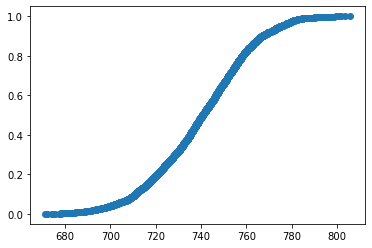

In [808]:
# simple visualization (I'm certain you can improve this :) )
plt.scatter(sum_sort, np.cumsum(sum_sort)/sum(sum_sort))

In [809]:
# Average impact of the variables on the score
df_score.mean()

total_income              23.70819
loan_amount               27.41702
term                      21.73665
interest_rate             15.93013
own_car                   26.68547
own_house                 24.28730
nr_children               24.68634
income_type               25.96501
education_type            25.93813
family_status             25.69140
housing_type              25.75589
region_population_ratio   25.86233
days_birth                31.00909
days_employed             25.62682
days_registration         29.45285
mobile_number              7.89175
phone_number              27.64181
email                     25.57345
days_phone_change         27.12860
occupation_type           26.04032
family_count              29.87754
EXT1                      29.51237
EXT2                      52.89117
EXT3                      40.01619
EXT4                      25.69140
EXT5                      16.04423
EXT6                      25.69140
EXT7                      25.42288
dtype: float64

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



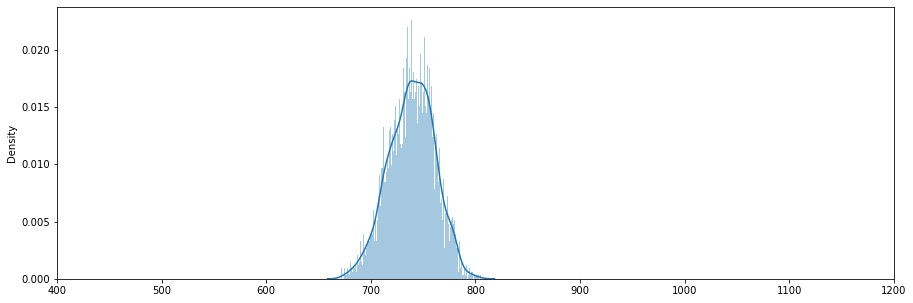

In [810]:
f, axes = plt.subplots(figsize=(15, 5))
plt.xlim(400,1200)
sns.distplot(sum_sort, bins = 150)
plt.show()

## Visualization of Score

The Score shows a normal distribution lying majorly in 650 to 800. The score of greater than 650 can be considered a good one whereas the score above 800 maybe coonsidered Excellent and rare


## Cost Reduction
- Defining functions to calculate Annuity, Present value, future value
- Setting parameters as per problem like lgd = 0.75 (75%) and ir_rf = 0.015
- Computing cost matrix to calculate cost by cost function
- Calculate Average cost and inverse class distribution
- Setting up data for models and runing GridSearch CV to optimise parameters of models
- tuning threshold, runing models
- Plotting cost and cut-offs for all models
- Repeating all the above steps with all models using normal data, under-sampled data and over-sampled data using SMOTE and RandomUnderSample

Cost can be reduced to an extent by adjusting various parameters in grid search cv for the models as well as other strategies shown in the below blocks.

In [811]:
# Annuity
def A(am, ir_c, n):
    return am * (ir_c*(1+ir_c)**n) / ((1+ir_c)**n - 1)

# Present Value
def PV(A, ir_rf, n):
    return A * (1-1/((1+ir_rf)**n)) / ir_rf

# Future Value
def FV(am, ir, n):
    return am * (1+ir)**n

In [812]:
#setting lgd as 75% and 1.5% risk free rate of interest
def cost_FP(am, n, ir_c, ir_rf=0.015):
    return PV(A(am,ir_c,n),ir_rf,n) - am

def cost_FN(am, lgd=0.75):
    return am*lgd

In [813]:
X_train.head(2)

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,housing_type,region_population_ratio,days_birth,days_employed,days_registration,mobile_number,phone_number,email,days_phone_change,occupation_type,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7
0,90000.00000,675000.00000,60,3.50122,1,1,1,0.16059,0.08330,-0.09501,-0.04073,0.01969,-14527,-7768,-1091.00000,1,0,0,0.00000,0.17802,3.00000,0.42601,0.61670,0.45790,0,1,0,0
1,180000.00000,679500.00000,48,3.35375,1,1,1,0.16059,0.08330,-0.09501,-0.04073,0.00663,-14511,-752,-110.00000,1,0,1,-456.00000,-0.15636,3.00000,0.33326,0.75747,0.00000,0,1,0,0


In [814]:
# compute cost matrix
# transform months -> years

cm_train = pd.DataFrame()
cm_train["cFP"] = cost_FP(X_train["loan_amount"], X_train["term"]/12, X_train["interest_rate"]/100)
cm_train["cFN"] = cost_FN(X_train["loan_amount"])
cm_train["cTP"] = 0.0
cm_train["cTN"] = 0.0

cm_valid = pd.DataFrame()
cm_valid["cFP"] = cost_FP(X_valid["loan_amount"], X_valid["term"]/12, X_valid["interest_rate"]/100)
cm_valid["cFN"] = cost_FN(X_valid["loan_amount"])
cm_valid["cTP"] = 0.0
cm_valid["cTN"] = 0.0

cm_test = pd.DataFrame()
cm_test["cFP"] = cost_FP(X_test["loan_amount"], X_test["term"]/12, X_test["interest_rate"]/100)
cm_test["cFN"] = cost_FN(X_test["loan_amount"])
cm_test["cTP"] = 0.0
cm_test["cTN"] = 0.0

In [815]:
def total_cost(true, pred, cTP, cFN, cFP, cTN):
    return true*(pred*cTP+(1-pred)*cFN)+(1-true)*(pred*cFP+(1-pred)*cTN)

In [816]:
# Average cost
weights_avg_cost = {0:1, 1:np.mean(cm_train["cFN"] / cm_train["cFP"])}
print("Avg. cost:", weights_avg_cost)

# Inverse class distribution
c0, c1 = np.bincount(y_train)
weights_inv = {0:1,1:c0/c1}
print("Inv. class distribution:", weights_inv)

Avg. cost: {0: 1, 1: 30.077888827266136}
Inv. class distribution: {0: 1, 1: 1.3273542600896862}


In [817]:
# evaluation metrics
def eval_metrics(proba, true, cm, t=0.5):
    proba = np.asarray(proba)
    true = np.asarray(true, dtype=int)
    pred = np.array(proba > t, dtype=int) # probability threshold

    auc = roc_auc_score(true, proba)
    f1 = f1_score(true, pred)
    cost = np.sum(total_cost(true, pred, **cm))

    return {
        'AUC': auc,
        'F1': f1,
        "Cost": cost,
    }

In [818]:
#Setup Grid search for logistic regression model and random forest model
logistic = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)

models = {"logistic":logistic, "rf":rf}

# grid search values 
grid_values = {
                "logistic":{
                    "solver":["liblinear"],
                    'penalty': ['l1', 'l2'],
                    'C':[0.25, 0.5, 1, 3], 
                    "max_iter":[200,300],
                    "class_weight": ["balanced"] # can be extended to custom class weights
                },
                "rf":{
                    "max_depth":np.arange(2,11,1),
                    "class_weight": ["balanced"] # can be extended to custom class weights
                }
            }

In [819]:
def run_GridSearch(name, data, model, param_grid, **kwargs):
    # save results
    metrics = kwargs.get("metrics", defaultdict(dict))

    #grid search parameters in grid_values
    #scoring is based on roc_auc -> outcome of gs is best model from grid search
    gs = GridSearchCV(model, param_grid = param_grid, scoring = kwargs.get("scoring", 'roc_auc'), cv=kwargs.get("cv", 3), refit=kwargs.get("refit", True))
    gs.fit(data["X_train"], data["y_train"])
    
    # predict
    proba_train   = gs.predict_proba(data["X_train"])[:,1]
    proba_valid   = gs.predict_proba(data["X_valid"])[:,1]

    # evaluate
    metrics[name]["train"] = eval_metrics(proba_train,data["y_train"],data["cm_train"])
    metrics[name]["valid"] = eval_metrics(proba_valid,data["y_valid"],data["cm_valid"])

    # prints
    if kwargs.get("print", True):
        print(f"{name}: {gs.best_params_}")
        for key, val in metrics[name].items():
            print(f"{key}: ", "\t".join([f"{k}: {v:.4f}" for k,v in val.items()]))

        cmtx = pd.DataFrame(
        confusion_matrix(data["y_valid"], np.round(proba_valid)), 
        index=['true:no', 'true:yes'], 
        columns=['pred:no', 'pred:yes'])

        print(cmtx)
    
    return gs, metrics

In [820]:
data_temp = {
    "X_train":X_train,
    "y_train":y_train,
    "X_valid":X_valid,
    "y_valid":y_valid,
    "cm_train":cm_train,
    "cm_valid":cm_valid,
}

model_dict = defaultdict(dict)
metric_dict = defaultdict(dict)

#loop through models in models dictionary
for name, model in models.items():
    model_dict[name], metric_dict = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], metrics=metric_dict)

logistic: {'C': 0.5, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
train:  AUC: 0.6897	F1: 0.5798	Cost: 1748829840.7429
valid:  AUC: 0.7090	F1: 0.2375	Cost: 65609469.2241
          pred:no  pred:yes
true:no      1899      1494
true:yes       73       244
rf: {'class_weight': 'balanced', 'max_depth': 8}
train:  AUC: 0.7723	F1: 0.6861	Cost: 933048478.5880
valid:  AUC: 0.7214	F1: 0.2197	Cost: 62135383.5663
          pred:no  pred:yes
true:no      1563      1830
true:yes       52       265


In [821]:
# save performance validation
EVAL = metric_dict.copy()

# evaluate on test set
# Note: I did not ask for this in the exercises
EVAL["logistic"]["test"] = eval_metrics(model_dict["logistic"].predict_proba(X_test)[:,1], y_test, cm_test)
EVAL["rf"]["test"] = eval_metrics(model_dict["rf"].predict_proba(X_test)[:,1], y_test, cm_test)

In [822]:
def tune_threshold(true, proba, cm):
    thresholds = np.arange(0, 1, 0.001)
    costs = [np.sum(total_cost(true, np.array(proba > t, dtype=int), **cm)) for t in thresholds]
    return thresholds, costs

In [823]:
# Logistic Regression

thresholds, costs = tune_threshold(y_train, model_dict["logistic"].predict_proba(X_train)[:,1], cm_train)

# best threshold
index = np.argmin(costs)
print(f"Threshold: {thresholds[index]:.3f}\tCost: {costs[index]:.0f}")

# evaluate cutoff on all data sets
EVAL["logistic+cutoff"]["train"] = eval_metrics(model_dict["logistic"].predict_proba(X_train)[:,1], y_train, cm_train, t=thresholds[np.argmin(costs)])
EVAL["logistic+cutoff"]["valid"] = eval_metrics(model_dict["logistic"].predict_proba(X_valid)[:,1], y_valid, cm_valid, t=thresholds[np.argmin(costs)])
EVAL["logistic+cutoff"]["test"] = eval_metrics(model_dict["logistic"].predict_proba(X_test)[:,1], y_test, cm_test, t=thresholds[np.argmin(costs)])
print(EVAL["logistic+cutoff"])

# Number of accepted applicants = pred:no = 78
cmtx = pd.DataFrame(
        confusion_matrix(y_valid, np.array(model_dict["logistic"].predict_proba(X_valid)[:,1] > thresholds[np.argmin(costs)], dtype=int)), 
        index=['true:no', 'true:yes'], 
        columns=['pred:no', 'pred:yes'])
print(cmtx)

Threshold: 0.267	Cost: 211080263
{'train': {'AUC': 0.6897429941151914, 'F1': 0.6444328901433559, 'Cost': 211080263.20553604}, 'valid': {'AUC': 0.7090307471031936, 'F1': 0.171238570241064, 'Cost': 64257858.542436026}, 'test': {'AUC': 0.7165429660806578, 'F1': 0.1700847689362866, 'Cost': 65597403.7944887}}
          pred:no  pred:yes
true:no       410      2983
true:yes        8       309


In [824]:
# Plot cost for all cutoffs
fig = go.Figure(data=go.Scatter(x=thresholds, y=costs))
fig.add_hline(y=np.min(costs), line_dash="dot", line_color="black")
fig.add_vline(x=thresholds[np.argmin(costs)], line_dash="dot", line_color="black")
fig.update_layout(
    title="Logistic Regression",
    xaxis_title="Threshold",
    yaxis_title="Cost"
)
fig.show()

In [825]:
# Random Forest 

thresholds, costs = tune_threshold(y_train, model_dict["rf"].predict_proba(X_train)[:,1], cm_train)

# best threshold
index = np.argmin(costs)
print(f"Threshold: {thresholds[index]:.3f}\tCost: {costs[index]:.0f}")

# evaluate cutoff on all data sets
EVAL["rf+cutoff"]["train"] = eval_metrics(model_dict["rf"].predict_proba(X_train)[:,1], y_train, cm_train, t=thresholds[np.argmin(costs)])
EVAL["rf+cutoff"]["valid"] = eval_metrics(model_dict["rf"].predict_proba(X_valid)[:,1], y_valid, cm_valid, t=thresholds[np.argmin(costs)])
EVAL["rf+cutoff"]["test"] = eval_metrics(model_dict["rf"].predict_proba(X_test)[:,1], y_test, cm_test, t=thresholds[np.argmin(costs)])
print(EVAL["rf+cutoff"])

# Number of accepted applicants = pred:no = 1394
cmtx = pd.DataFrame(
        confusion_matrix(y_valid, np.array(model_dict["rf"].predict_proba(X_valid)[:,1] > thresholds[np.argmin(costs)], dtype=int)), 
        index=['true:no', 'true:yes'], 
        columns=['pred:no', 'pred:yes'])
print(cmtx)

Threshold: 0.273	Cost: 198736186
{'train': {'AUC': 0.7722855062454924, 'F1': 0.651543603996094, 'Cost': 198736185.81693858}, 'valid': {'AUC': 0.7213710543417929, 'F1': 0.1727019498607242, 'Cost': 62021764.533409506}, 'test': {'AUC': 0.7249374988959455, 'F1': 0.17111111111111113, 'Cost': 64110212.939181365}}
          pred:no  pred:yes
true:no       430      2963
true:yes        7       310


In [826]:
# Plot cost for all cutoffs
fig = go.Figure(data=go.Scatter(x=thresholds, y=costs))
fig.add_hline(y=np.min(costs), line_dash="dot", line_color="black")
fig.add_vline(x=thresholds[np.argmin(costs)], line_dash="dot", line_color="black")
fig.update_layout(
    title="Random Forest",
    xaxis_title="Threshold",
    yaxis_title="Cost"
)
fig.show()

In [827]:
# conda install -c conda-forge imbalanced-learn

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [828]:
# setup sampling techniques

# SMOTE
sample_over = SMOTE(random_state=42)
X_train_over, y_train_over = sample_over.fit_resample(X_train, y_train)

# RandomUnderSampler
sample_under = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = sample_under.fit_resample(X_train, y_train)

print(f"SMOTE: {np.bincount(y_train_over)}")
print(f"Random Undersampling: {np.bincount(y_train_under)}")

SMOTE: [11544 11544]
Random Undersampling: [8697 8697]


In [829]:
# compute new cost matrix
cm_train_over = pd.DataFrame()
cm_train_over["cFP"] = cost_FP(X_train_over["loan_amount"], X_train_over["term"]/12, X_train_over["interest_rate"]/100)
cm_train_over["cFN"] = cost_FN(X_train_over["loan_amount"])
cm_train_over["cTP"] = 0.0
cm_train_over["cTN"] = 0.0

data_temp = {
    "X_train":X_train_over,
    "y_train":y_train_over,
    "X_valid":X_valid,
    "y_valid":y_valid,
    "cm_train":cm_train_over,
    "cm_valid":cm_valid,
}

model_dict = defaultdict(dict)
metric_dict = defaultdict(dict)

#loop through models in models dictionary
for name, model in models.items():
    model_dict[name], metric_dict = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], metrics=metric_dict)
    EVAL[name+"+over"]["train"] = eval_metrics(model_dict[name].predict_proba(X_train)[:,1], y_train, cm_train)
    EVAL[name+"+over"]["valid"] = eval_metrics(model_dict[name].predict_proba(X_valid)[:,1], y_valid, cm_valid)
    EVAL[name+"+over"]["test"] = eval_metrics(model_dict[name].predict_proba(X_test)[:,1], y_test, cm_test)

logistic: {'C': 0.25, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
train:  AUC: 0.7031	F1: 0.6383	Cost: 2127585674.1354
valid:  AUC: 0.6953	F1: 0.2327	Cost: 69151198.3600
          pred:no  pred:yes
true:no      1933      1460
true:yes       83       234
rf: {'class_weight': 'balanced', 'max_depth': 10}
train:  AUC: 0.8786	F1: 0.8030	Cost: 772658136.7366
valid:  AUC: 0.7188	F1: 0.2277	Cost: 64938660.1375
          pred:no  pred:yes
true:no      1780      1613
true:yes       69       248


In [830]:
# compute new cost matrix
cm_train_under = pd.DataFrame()
cm_train_under["cFP"] = cost_FP(X_train_under["loan_amount"], X_train_under["term"]/12, X_train_under["interest_rate"]/100)
cm_train_under["cFN"] = cost_FN(X_train_under["loan_amount"])
cm_train_under["cTP"] = 0.0
cm_train_under["cTN"] = 0.0

data_temp = {
    "X_train":X_train_under,
    "y_train":y_train_under,
    "X_valid":X_valid,
    "y_valid":y_valid,
    "cm_train":cm_train_under,
    "cm_valid":cm_valid,
}

model_dict = defaultdict(dict)
metric_dict = defaultdict(dict)

#loop through models in models dictionary
for name, model in models.items():
    model_dict[name], metric_dict = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], metrics=metric_dict)
    EVAL[name+"+under"]["train"] = eval_metrics(model_dict[name].predict_proba(X_train)[:,1], y_train, cm_train)
    EVAL[name+"+under"]["valid"] = eval_metrics(model_dict[name].predict_proba(X_valid)[:,1], y_valid, cm_valid)
    EVAL[name+"+under"]["test"] = eval_metrics(model_dict[name].predict_proba(X_test)[:,1], y_test, cm_test)

logistic: {'C': 3, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
train:  AUC: 0.6878	F1: 0.6156	Cost: 1719402635.5880
valid:  AUC: 0.7085	F1: 0.2353	Cost: 65805282.9228
          pred:no  pred:yes
true:no      1895      1498
true:yes       75       242
rf: {'class_weight': 'balanced', 'max_depth': 9}
train:  AUC: 0.8285	F1: 0.7724	Cost: 620978233.7622
valid:  AUC: 0.7266	F1: 0.2173	Cost: 60990406.9000
          pred:no  pred:yes
true:no      1495      1898
true:yes       47       270


## Evaluation of models
- Comparison of all the models and different sampling procedures with three different measures: AUC, F1, Cost
- Prediction on test dataset
- Calculating the accuracy on test set
- Selecting the best model on the basis of Cost measure

### AUC: 
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows: TPR=TP/(TP+FN)

False Positive Rate (FPR) is defined as follows: FPR=FP/(FP+TN)

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve .

### F1 Score
F1 = 2 * ((Precision*Recall)/(Precision+Recall))

### Cost
Cost accuracy is calculated by calculating total cost by calculating cost matrix using the formula.

In [831]:
# Display full overview
overview = pd.DataFrame(pd.concat({k: pd.DataFrame(v) for k,v in EVAL.items()}, axis=1)).T

# convert cost to million
overview["Cost"] /= 1_000_000

overview

AUC      F1       Cost
logistic        train 0.68974 0.57982 1748.82984
                valid 0.70903 0.23747   65.60947
                test  0.71654 0.22503   74.00318
rf              train 0.77229 0.68605  933.04848
                valid 0.72137 0.21973   62.13538
                test  0.72494 0.22345   61.76929
logistic+cutoff train 0.68974 0.64443  211.08026
                valid 0.70903 0.17124   64.25786
                test  0.71654 0.17008   65.59740
rf+cutoff       train 0.77229 0.65154  198.73619
                valid 0.72137 0.17270   62.02176
                test  0.72494 0.17111   64.11021
logistic+over   train 0.68025 0.57343 1801.57867
                valid 0.69528 0.23272   69.15120
                test  0.71773 0.23713   71.92932
rf+over         train 0.84533 0.74699  758.32925
                valid 0.71885 0.22773   64.93866
                test  0.71773 0.22979   67.70730
logistic+under  train 0.68960 0.58052 1739.89740
                valid 0.70849 0.23529   65.80528
                test  0.71664 0.22459   74.11313
rf+under        train 0.81406 0.72316  646.72883
                valid 0.72664 0.21730   60.99041
                test  0.72658 0.21983   61.60384

In [832]:
# RF + under tuning performs best on cost metric
overview.iloc[overview.index.get_level_values(1) == "test",:].sort_values("Cost", ascending=True)

,,AUC,F1,Cost
rf+under,test,0.72658,0.21983,61.60384
rf,test,0.72494,0.22345,61.76929
rf+cutoff,test,0.72494,0.17111,64.11021
logistic+cutoff,test,0.71654,0.17008,65.59740
rf+over,test,0.71773,0.22979,67.70730
logistic+over,test,0.71773,0.23713,71.92932
logistic,test,0.71654,0.22503,74.00318
logistic+under,test,0.71664,0.22459,74.11313


## Best Model: Random Forest with Under-Sampling
- Description of the best model
- Plotting the cost graph and marking the least cost

In [833]:
data_temp = {
    "X_train":X_train,
    "y_train":y_train,
    "X_valid":X_valid,
    "y_valid":y_valid,
    "cm_train":cm_train,
    "cm_valid":cm_valid,
}

name = "rf"
best_model, metrics = run_GridSearch(name=name, data=data_temp, model=models[name], param_grid=grid_values[name], print=False)

thresholds, costs_train = tune_threshold(y_train, best_model.predict_proba(X_train)[:,1], cm_train)
_, costs_test = tune_threshold(y_test, best_model.predict_proba(X_test)[:,1], cm_test)


# Display selected cutoff and true costs
fig = go.Figure(data=go.Scatter(x=thresholds, y=costs_test))
fig.add_vline(x=thresholds[np.argmin(costs_test)], line_dash="dot", line_color="black")
fig.update_layout(
    title="RF+UnderSampling",
    xaxis_title="Threshold",
    yaxis_title="Cost"
)
fig.show()

The minimum cost is 0.413

In [872]:
model_dict['rf']

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='roc_auc')

In [871]:
model_dict['rf'].best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=9, random_state=42)